In [7]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysd
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy as sp

# Load Calibration data

In [8]:
data = pd.read_csv("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/data/dynamic/calibration_incidence.csv", sep=',',decimal='.')
data=data.drop("Unnamed: 0",axis=1)
data.head(23)


,year,var,Lower,Mean,Upper
0,2000,e_inc_num,56000,139000,259000
1,2001,e_inc_num,57000,159000,312000
2,2002,e_inc_num,57000,175000,357000
3,2003,e_inc_num,54000,206000,456000
4,2004,e_inc_num,54000,221000,501000
5,2005,e_inc_num,56000,226000,510000
6,2006,e_inc_num,56000,239000,549000
7,2007,e_inc_num,60000,235000,525000
8,2008,e_inc_num,66000,221000,467000
9,2009,e_inc_num,68000,228000,483000


Text(0.5, 1.0, 'Estimated Incident cases of TB')

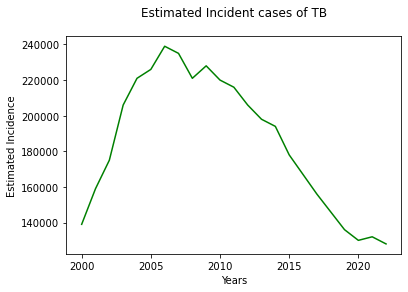

In [9]:
plt.plot(data["year"], data['Mean'],label="mean_estimate",color="green")
plt.xlabel('Years')
plt.ylabel('Estimated Incidence')
plt.title("Estimated Incident cases of TB",pad=20)

# Load Model

In [10]:
model = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V10_years.mdl")

In [11]:
model_output = model.run()


<AxesSubplot:>

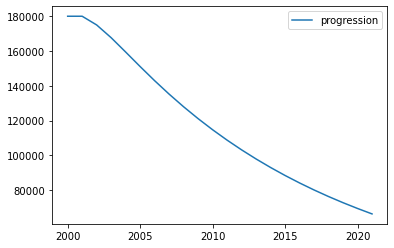

In [12]:
model_output.plot(y="progression")

## Calibration

In [13]:
#Set up observable and claibration parameters
observable = "progression"
parameter1 = 'transmission rate'
parameter2 = 'relapse rate'
parameter3 = 'initial incident'
parameter4="progression rate"
parameter5 = 'initial latent'
parameter6 = 'progression time'




def error(param_list):
    #unpack the parameter list
    parameter1_value,parameter2_value,parameter3_value,parameter4_value,parameter5_value,parameter6_value = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'transmission rate':parameter1_value,
                               'relapse rate':parameter2_value,
                               'initial incident': parameter3_value,
                               "progression rate":parameter4_value,
                               'initial latent': parameter5_value,
                               'progression time': parameter6_value
                              },
                       return_columns=['progression'])
    #print(result['progression'] -data['Mean'])
    
    result=result.reset_index(drop=True)
    #print(result)
    calDat=data.reset_index(drop=True)
    calDat=calDat["Mean"]
    
    error=sum((result['progression'] - calDat)**2)
    #print(error)
    #return the sum of the squared errors
    return  error

In [14]:
parameter1_guess = 0.05
parameter1_bounds = (0.0, 1)

parameter2_guess = 0.1
parameter2_bounds = (0.004, 0.1)

parameter3_guess = 100000
parameter3_bounds = (1, 3000000)

parameter4_guess = 0.08
parameter4_bounds = (0, 0.2)


parameter5_guess = 100000
parameter5_bounds = (1, 3000000)

parameter6_guess = 2
parameter6_bounds = (1,5)



res = sp.optimize.minimize(error,
                           x0=[parameter1_guess,parameter2_guess,parameter3_guess,parameter4_guess,parameter5_guess,parameter6_guess],
                           method='L-BFGS-B',
                           bounds=[parameter1_bounds,parameter2_bounds,parameter3_bounds,parameter4_bounds,parameter5_bounds,parameter6_bounds])
res

      fun: nan
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan, nan, nan, nan, nan])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 147
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([5.e-02, 1.e-01, 1.e+05, 8.e-02, 1.e+05, 2.e+00])

In [15]:
p1, p2, p3,p4,p5,p6= res.x
result = model.run(params=
                   {
                       'transmission rate':p1,
                               'relapse rate':p2,
                               'initial incident': p3,
                               "progression rate":p4,
                       'initial latent': p5,
                       'progression time': p6
                   },
                   return_columns=['progression'])

result

,progression
2000,8000.000000
2001,8000.000000
2002,7845.815789
2003,7574.175029
2004,7235.478471
2005,6869.620149
2006,6502.889200
2007,6150.711093
2008,5821.108763
2009,5517.471161


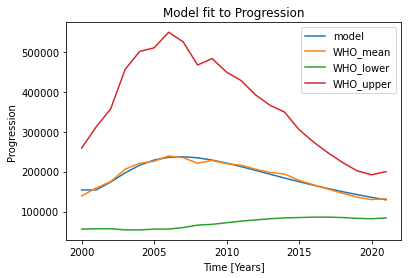

In [249]:
plt.plot(result.index, result['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='WHO_mean');
plt.plot(data["year"], data['Lower'], label='WHO_lower');
plt.plot(data["year"], data['Upper'], label='WHO_upper');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')
plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)

## Explore Calibrated

In [16]:
model_cal = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V10_years_cal.mdl")

In [17]:
model_cal_output = model_cal.run()
display(model_cal_output)

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,Detection,Cumulative Cases,progression,Relapse,CDR,CFR,...,total pop,general mortality,infection,initial incident,initial latent,Latent TB infection,Detected and Treated TB,relapse rate,transmission rate,progression rate
2000,2021,2000,1,1,906660.000000,0.000000e+00,154088.442000,220.000000,0.460000,0.450,...,3.805500e+07,0.008,668418.403415,1971000.0,988380,9.883800e+05,5.500000e+04,0.004,0.3683,0.1559
2001,2021,2000,1,1,519325.253320,1.540884e+05,154088.442000,3844.000000,0.460000,0.450,...,3.874219e+07,0.008,377325.490967,1971000.0,988380,1.494803e+06,9.610000e+05,0.004,0.3683,0.1559
2002,2021,2000,1,1,329455.261087,3.081769e+05,173994.983300,5875.173013,0.460000,0.450,...,3.947469e+07,0.008,237777.958961,1971000.0,988380,1.706082e+06,1.468793e+06,0.004,0.3683,0.1559
2003,2021,2000,1,1,245655.898511,4.821719e+05,197187.320830,7122.491981,0.460000,0.450,...,4.023733e+07,0.008,176786.008692,1971000.0,988380,1.756216e+06,1.780623e+06,0.004,0.3683,0.1559
2004,2021,2000,1,1,215459.355707,6.793592e+05,216502.702023,8019.645672,0.460000,0.450,...,4.102205e+07,0.008,154866.697569,1971000.0,988380,1.721765e+06,2.004911e+06,0.004,0.3683,0.1559
2005,2021,2000,1,1,209824.931337,8.958619e+05,229593.757508,8785.247347,0.460000,0.450,...,4.182493e+07,0.008,150729.910437,1971000.0,988380,1.646355e+06,2.196312e+06,0.004,0.3683,0.1559
2006,2021,2000,1,1,213412.770779,1.125456e+06,236419.843962,9519.124104,0.460000,0.450,...,4.264432e+07,0.008,153247.104760,1971000.0,988380,1.554320e+06,2.379781e+06,0.004,0.3683,0.1559
2007,2021,2000,1,1,218664.540460,1.361875e+06,237907.110465,10258.545698,0.460000,0.450,...,4.347981e+07,0.008,156959.908326,1971000.0,988380,1.458713e+06,2.564636e+06,0.004,0.3683,0.1559
2008,2021,2000,1,1,222285.817093,1.599783e+06,235261.237492,11010.101311,0.460000,0.435,...,4.433158e+07,0.008,159499.024523,1971000.0,988380,1.366096e+06,2.752525e+06,0.004,0.3683,0.1559
2009,2021,2000,1,1,223483.009673,1.835044e+06,229641.888724,11767.123364,0.460000,0.420,...,4.520069e+07,0.008,160298.883172,1971000.0,988380,1.279405e+06,2.941781e+06,0.004,0.3683,0.1559


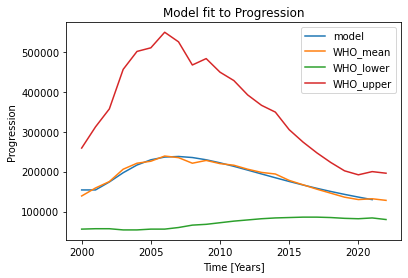

In [18]:
plt.plot(model_cal_output.index, model_cal_output['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='WHO_mean');
plt.plot(data["year"], data['Lower'], label='WHO_lower');
plt.plot(data["year"], data['Upper'], label='WHO_upper');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')
plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)